In [1]:
# Minimal test version
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import transforms
from PIL import Image
import os
# Early Stopping Class
class EarlyStopping:
    def __init__(self, patience=7, min_delta=0, restore_best_weights=True):
        self.patience = patience
        self.min_delta = min_delta
        self.restore_best_weights = restore_best_weights
        self.best_model = None
        self.best_loss = None
        self.counter = 0
        self.status = ""
        
    def __call__(self, model, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
            self.best_model = model.state_dict().copy()
            self.status = f"Improvement from None to {val_loss:.4f}"
            
        elif val_loss < self.best_loss - self.min_delta:
            self.best_loss = val_loss
            self.best_model = model.state_dict().copy()
            self.counter = 0
            self.status = f"Improvement to {val_loss:.4f}"
            
        else:
            self.counter += 1
            self.status = f"No improvement. Counter: {self.counter}/{self.patience}"
            if self.counter >= self.patience:
                if self.restore_best_weights:
                    model.load_state_dict(self.best_model)
                return True
        return False
# Test basic functionality
print("Testing PyTorch and CUDA...")
print(f"CUDA available: {torch.cuda.is_available()}")
print(f"CUDA device count: {torch.cuda.device_count()}")

if torch.cuda.is_available():
    x = torch.randn(3, 3).cuda()
    print(f"Tensor on GPU: {x.device}")
    print("CUDA is working!")

# Test data loading
print("\nTesting data loading...")
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
])

class SimpleDataset(torch.utils.data.Dataset):
    def __init__(self, root_dir):
        self.root_dir = root_dir
        self.images = []
        for class_name in ['glioma', 'meningioma', 'notumor', 'pituitary']:
            class_path = os.path.join(root_dir, class_name)
            if os.path.exists(class_path):
                for img_name in os.listdir(class_path)[:10]:  # Just 10 images per class
                    if img_name.lower().endswith(('.jpg', '.jpeg', '.png')):
                        self.images.append(os.path.join(class_path, img_name))
    
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        img = Image.open(self.images[idx]).convert('RGB')
        img = transforms.Resize((64, 64))(img)
        img = transforms.ToTensor()(img)
        return img, 0  # Dummy label

try:
    dataset = SimpleDataset('archive/Training')
    print(f"Loaded {len(dataset)} images")
    
    loader = DataLoader(dataset, batch_size=4, shuffle=True, num_workers=0)
    
    for i, (images, labels) in enumerate(loader):
        print(f"Batch {i}: {images.shape}")
        if i == 2:  # Just test 3 batches
            break
            
    print("Data loading successful!")
    
except Exception as e:
    print(f"Error: {e}")

Testing PyTorch and CUDA...
CUDA available: True
CUDA device count: 1
Tensor on GPU: cuda:0
CUDA is working!

Testing data loading...
Loaded 40 images
Batch 0: torch.Size([4, 3, 64, 64])
Batch 1: torch.Size([4, 3, 64, 64])
Batch 2: torch.Size([4, 3, 64, 64])
Data loading successful!


In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, f1_score, accuracy_score
class EarlyStopping:
    def __init__(self, patience=7, min_delta=0, restore_best_weights=True):
        self.patience = patience
        self.min_delta = min_delta
        self.restore_best_weights = restore_best_weights
        self.best_model = None
        self.best_loss = None
        self.counter = 0
        self.status = ""
        
    def __call__(self, model, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
            self.best_model = model.state_dict().copy()
            self.status = f"Improvement from None to {val_loss:.4f}"
            
        elif val_loss < self.best_loss - self.min_delta:
            self.best_loss = val_loss
            self.best_model = model.state_dict().copy()
            self.counter = 0
            self.status = f"Improvement to {val_loss:.4f}"
            
        else:
            self.counter += 1
            self.status = f"No improvement. Counter: {self.counter}/{self.patience}"
            if self.counter >= self.patience:
                if self.restore_best_weights:
                    model.load_state_dict(self.best_model)
                return True
        return False
# Simple Dataset with error handling
class BrainTumorDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.classes = ['glioma', 'meningioma', 'notumor', 'pituitary']
        self.class_to_idx = {cls: idx for idx, cls in enumerate(self.classes)}
        self.images = []
        self.labels = []
        
        print(f"Loading data from: {root_dir}")
        
        for class_name in self.classes:
            class_path = os.path.join(root_dir, class_name)
            if os.path.exists(class_path):
                image_files = [f for f in os.listdir(class_path) 
                             if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
                print(f"Found {len(image_files)} images in {class_name}")
                
                for img_name in image_files:
                    self.images.append(os.path.join(class_path, img_name))
                    self.labels.append(self.class_to_idx[class_name])
            else:
                print(f"Warning: Directory {class_path} not found!")
        
        print(f"Total images loaded: {len(self.images)}")
    
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        try:
            img_path = self.images[idx]
            image = Image.open(img_path).convert('RGB')
            label = self.labels[idx]
            
            if self.transform:
                image = self.transform(image)
            
            return image, label
        except Exception as e:
            print(f"Error loading image {img_path}: {e}")
            # Return a dummy image
            dummy_image = torch.zeros(3, 128, 128)
            return dummy_image, 0

# Very Simple CNN
class SimpleCNN(nn.Module):
    def __init__(self, num_classes=4):
        super(SimpleCNN, self).__init__()
        
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
            
            nn.Conv2d(32, 64, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
            
            nn.Conv2d(64, 128, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
        )
        
        self.classifier = nn.Sequential(
            nn.AdaptiveAvgPool2d((1, 1)),
            nn.Flatten(),
            nn.Linear(128, 64),
            nn.ReLU(inplace=True),
            nn.Dropout(0.3),
            nn.Linear(64, num_classes)
        )
    
    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

# Test data loading first
def test_data_loading():
    print("Testing data loading...")
    
    transform = transforms.Compose([
        transforms.Resize((128, 128)),
        transforms.ToTensor(),
    ])
    
    try:
        train_dataset = BrainTumorDataset('archive/Training', transform=transform)
        test_dataset = BrainTumorDataset('archive/Testing', transform=transform)
        
        print(f"Train dataset size: {len(train_dataset)}")
        print(f"Test dataset size: {len(test_dataset)}")
        
        # Test loading a few samples
        for i in range(3):
            img, label = train_dataset[i]
            print(f"Sample {i}: shape {img.shape}, label {label}")
            
        return True
    except Exception as e:
        print(f"Data loading error: {e}")
        return False

# Fast training function
def train_fast(model, train_loader, val_loader, criterion, optimizer, num_epochs, device):
    train_losses = []
    val_losses = []
    train_accs = []
    val_accs = []
    
    print(f"\nStarting training for {num_epochs} epochs...")
    # Initialize early stopping
    early_stopping = EarlyStopping(patience=10, min_delta=0.001, restore_best_weights=True)
    for epoch in range(num_epochs):
        # Training
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        batch_count = 0
        
        print(f"Epoch {epoch+1}/{num_epochs}")
        
        for batch_idx, (inputs, labels) in enumerate(train_loader):
            inputs, labels = inputs.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            batch_count += 1
            
            if (batch_idx + 1) % 10 == 0:
                avg_loss = running_loss / batch_count
                acc = 100 * correct / total
                print(f'  Batch {batch_idx+1}/{len(train_loader)} - Loss: {avg_loss:.4f}, Acc: {acc:.2f}%')
        
        train_loss = running_loss / len(train_loader)
        train_acc = 100 * correct / total
        train_losses.append(train_loss)
        train_accs.append(train_acc)
        
        # Validation
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0
        
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                
                val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        
        val_loss = val_loss / len(val_loader)
        val_acc = 100 * correct / total
        val_losses.append(val_loss)
        val_accs.append(val_acc)
        
        print(f'Epoch {epoch+1} Summary:')
        print(f'  Train - Loss: {train_loss:.4f}, Acc: {train_acc:.2f}%')
        print(f'  Val   - Loss: {val_loss:.4f}, Acc: {val_acc:.2f}%')
        print('-' * 50)
        print(f'  Early Stopping: {early_stopping.status}')
        print('-' * 50)
        # Check early stopping
        if early_stopping(model, val_loss):
            print(f"\nEarly stopping triggered after {epoch+1} epochs!")
            print(f"Best validation loss: {early_stopping.best_loss:.4f}")
            break
    return train_losses, val_losses, train_accs, val_accs

def evaluate_model(model, test_loader, device, classes):
    model.eval()
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.numpy())
    
    accuracy = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds, average='weighted')
    
    print(f'\nTest Accuracy: {accuracy * 100:.2f}%')
    print(f'F1 Score: {f1:.4f}')
    print('\nClassification Report:')
    print(classification_report(all_labels, all_preds, target_names=classes))
    
    return all_preds, all_labels, accuracy, f1
def plot_confusion_matrix(y_true, y_pred, classes, title='Confusion Matrix'):
    """
    Plot a beautiful confusion matrix using seaborn
    """
    cm = confusion_matrix(y_true, y_pred)
    
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=classes, yticklabels=classes,
                cbar_kws={'shrink': 0.8})
    
    plt.title(title, fontsize=16, fontweight='bold', pad=20)
    plt.xlabel('Predicted Labels', fontsize=12, fontweight='bold')
    plt.ylabel('True Labels', fontsize=12, fontweight='bold')
    
    # Improve readability
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    
    plt.tight_layout()
    plt.savefig('yolo_confusion_matrix.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    return cm
def plot_training_history(train_losses, val_losses, train_accs, val_accs):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    
    epochs = range(1, len(train_losses) + 1)
    ax1.plot(epochs, train_losses, 'b-', label='Training Loss')
    ax1.plot(epochs, val_losses, 'r-', label='Validation Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.set_title('Training History - Loss')
    ax1.legend()
    ax1.grid(True)
    
    ax2.plot(epochs, train_accs, 'b-', label='Training Accuracy')
    ax2.plot(epochs, val_accs, 'r-', label='Validation Accuracy')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy (%)')
    ax2.set_title('Training History - Accuracy')
    ax2.legend()
    ax2.grid(True)
    
    plt.tight_layout()
    plt.savefig('training_history.png', dpi=300, bbox_inches='tight')
    plt.show()

# Main execution with better error handling
if __name__ == '__main__':
    # First test data loading
    if not test_data_loading():
        print("Data loading failed! Check your data paths.")
        exit()
    
    # Hyperparameters
    BATCH_SIZE = 32  # Start with smaller batch size
    NUM_EPOCHS = 100   # Just 100 epochs to test
    LEARNING_RATE = 0.001
    IMG_SIZE = 128
    
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f'\nUsing device: {device}')
    
    if torch.cuda.is_available():
        print(f'GPU: {torch.cuda.get_device_name()}')
        print(f'CUDA version: {torch.version.cuda}')
    
    # Simple transforms
    transform = transforms.Compose([
        transforms.Resize((IMG_SIZE, IMG_SIZE)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                           std=[0.229, 0.224, 0.225])
    ])
    
    print("\nCreating datasets...")
    train_dataset = BrainTumorDataset('archive/Training', transform=transform)
    test_dataset = BrainTumorDataset('archive/Testing', transform=transform)
    
    print(f"Train samples: {len(train_dataset)}")
    print(f"Test samples: {len(test_dataset)}")
    
    # Simple DataLoader without multiprocessing first
    train_loader = DataLoader(
        train_dataset, 
        batch_size=BATCH_SIZE, 
        shuffle=True, 
        num_workers=0,  # Start with 0 to avoid multiprocessing issues
        pin_memory=True
    )
    
    test_loader = DataLoader(
        test_dataset, 
        batch_size=BATCH_SIZE, 
        shuffle=False, 
        num_workers=0,
        pin_memory=True
    )
    
    # Test one batch
    print("\nTesting one batch...")
    for inputs, labels in train_loader:
        print(f"Batch input shape: {inputs.shape}")
        print(f"Batch labels: {labels[:10]}")  # First 10 labels
        break
    
    # Create model
    model = SimpleCNN(num_classes=4).to(device)
    
    # Count parameters
    total_params = sum(p.numel() for p in model.parameters())
    print(f"\nModel Parameters: {total_params:,}")
    
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
    
    print("\nStarting training...")
    try:
        train_losses, val_losses, train_accs, val_accs = train_fast(
            model, train_loader, test_loader, criterion, optimizer, NUM_EPOCHS, device
        )
        
        # Evaluate
        classes = ['glioma', 'meningioma', 'notumor', 'pituitary']
        predictions, labels, accuracy, f1 = evaluate_model(model, test_loader, device, classes)
        
        plot_training_history(train_losses, val_losses, train_accs, val_accs)

         # Plot confusion matrix
        print("\nGenerating Confusion Matrix...")
        cm = plot_confusion_matrix(labels, predictions, classes, 
                                 title='SimpleCNN Model - Confusion Matrix')
        # Save model
        torch.save(model.state_dict(), 'brain_tumor_model.pth')
        print('\nModel saved as brain_tumor_model.pth')
        
    except Exception as e:
        print(f"Training error: {e}")
        import traceback
        traceback.print_exc()

Testing data loading...
Loading data from: archive/Training
Found 1321 images in glioma
Found 1339 images in meningioma
Found 1595 images in notumor
Found 1457 images in pituitary
Total images loaded: 5712
Loading data from: archive/Testing
Found 300 images in glioma
Found 306 images in meningioma
Found 405 images in notumor
Found 300 images in pituitary
Total images loaded: 1311
Train dataset size: 5712
Test dataset size: 1311
Sample 0: shape torch.Size([3, 128, 128]), label 0
Sample 1: shape torch.Size([3, 128, 128]), label 0
Sample 2: shape torch.Size([3, 128, 128]), label 0

Using device: cuda
GPU: NVIDIA GeForce RTX 3060 Laptop GPU
CUDA version: 12.1

Creating datasets...
Loading data from: archive/Training
Found 1321 images in glioma
Found 1339 images in meningioma
Found 1595 images in notumor
Found 1457 images in pituitary
Total images loaded: 5712
Loading data from: archive/Testing
Found 300 images in glioma
Found 306 images in meningioma
Found 405 images in notumor
Found 300 i

KeyboardInterrupt: 

C:\Users\G15\AppData\Local\Temp\ipykernel_13808\3128803229.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_location=devi

Success: Model loaded from brain_tumor_model.pth

Displaying 6 random inference samples...


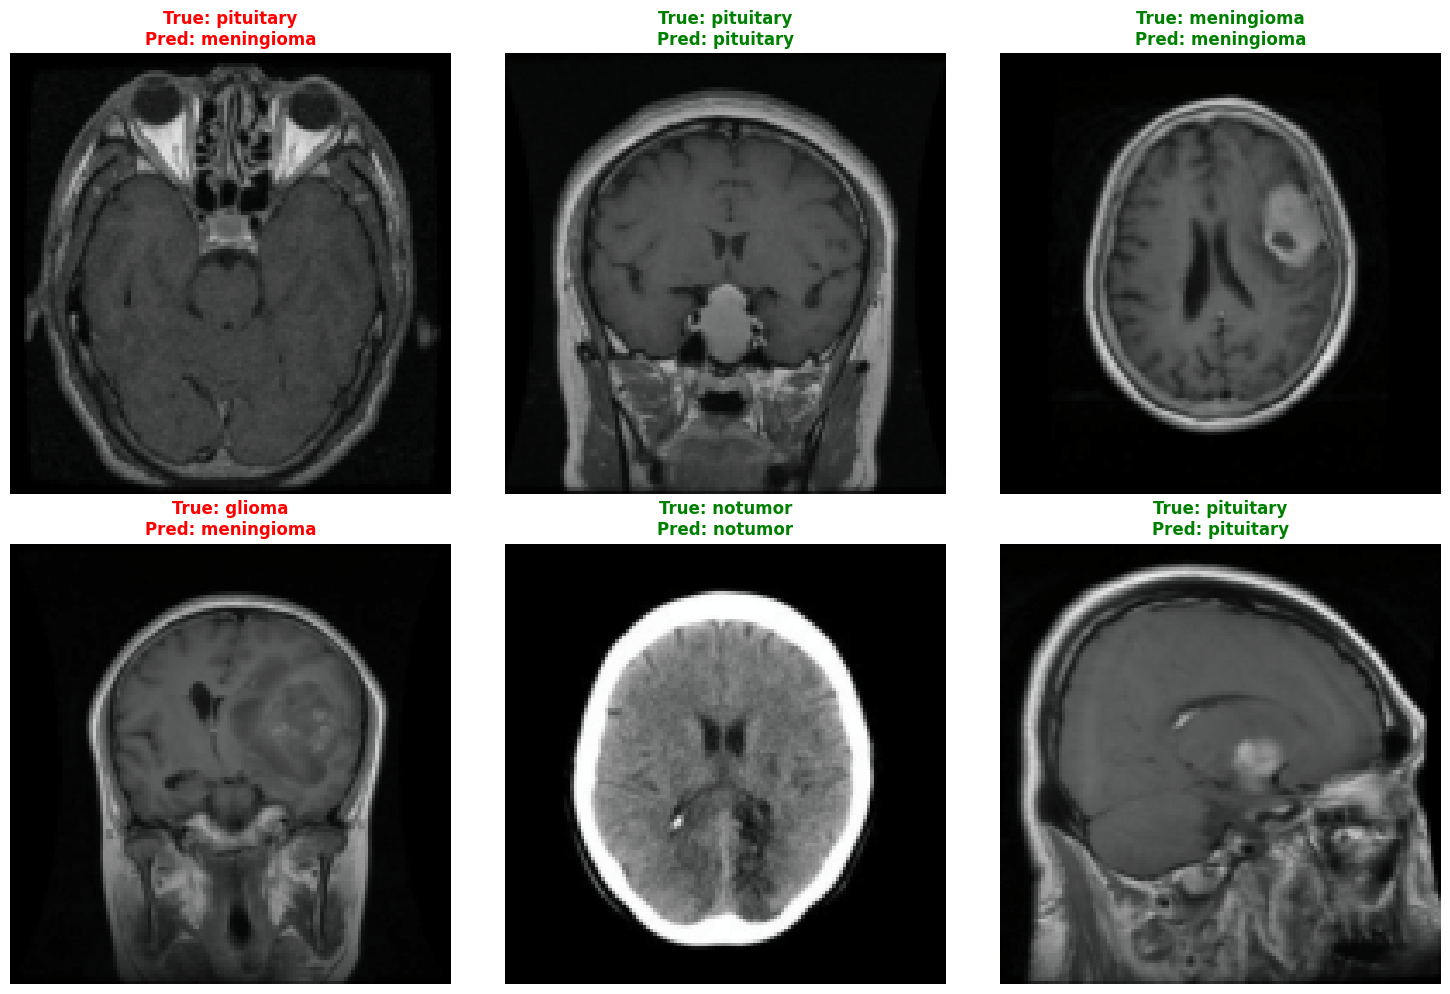

In [8]:
import random

# 2. Load the weights from the file
model_path = 'brain_tumor_model.pth'
if os.path.exists(model_path):
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.eval()  # Set to evaluation mode for inference
    print(f"Success: Model loaded from {model_path}")
else:
    print(f"Error: Model file '{model_path}' not found.")


def show_inference_samples(dataset, model, classes, device, num_samples=6):
    """
    Picks random samples from the dataset, runs inference, and displays results
    with True vs Predicted labels.
    """
    model.eval()
    
    # 1. Pick random indices
    indices = random.sample(range(len(dataset)), num_samples)
    
    # 2. Setup Plot
    rows = 2
    cols = 3
    fig, axes = plt.subplots(rows, cols, figsize=(15, 10))
    axes = axes.flatten()
    
    # Parameters for un-normalizing (must match your transform)
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    
    print(f"\nDisplaying {num_samples} random inference samples...")
    
    with torch.no_grad():
        for i, idx in enumerate(indices):
            image_tensor, true_label_idx = dataset[idx]
            
            # 3. Prepare input for model (Add batch dimension: [C,H,W] -> [1,C,H,W])
            input_tensor = image_tensor.unsqueeze(0).to(device)
            
            # 4. Run Inference
            outputs = model(input_tensor)
            _, predicted_idx = torch.max(outputs, 1)
            predicted_idx = predicted_idx.item()
            
            # 5. Un-normalize image for display
            # Convert: Tensor(C,H,W) -> Numpy(H,W,C)
            img_display = image_tensor.permute(1, 2, 0).cpu().numpy()
            # Inverse normalize: pixel = (pixel * std) + mean
            img_display = std * img_display + mean
            # Clip values to valid range [0, 1]
            img_display = np.clip(img_display, 0, 1)
            
            # 6. Plotting
            ax = axes[i]
            ax.imshow(img_display)
            
            true_class = classes[true_label_idx]
            pred_class = classes[predicted_idx]
            
            # Green title if correct, Red if wrong
            color = 'green' if true_class == pred_class else 'red'
            
            ax.set_title(f"True: {true_class}\nPred: {pred_class}", 
                         color=color, fontsize=12, fontweight='bold')
            ax.axis('off')
            
    plt.tight_layout()
    plt.savefig('inference_samples_scnn.png', dpi=300, bbox_inches='tight')
    plt.show()

# --- Execute the function ---
# Ensure this runs after your model is trained and 'test_dataset' is defined
if __name__ == '__main__':
    # Re-define classes locally if needed, or access from dataset
    class_names = ['glioma', 'meningioma', 'notumor', 'pituitary']
    
    # Call the function
    show_inference_samples(test_dataset, model, class_names, device)
